# Load Data

In [1]:
import pickle
from google.colab import data_table

with open('data_vars.pkl','rb') as f:  # Python 3: open(..., 'rb')
    na_ixes = pickle.load(f)
    gfd_all_df = pickle.load(f)
    gdf_norm = pickle.load(f)
    names_dict = pickle.load(f)

f = open('pp_vars.pkl', 'rb')
scaler = pickle.load(f)
f.close()

data_table.DataTable(gfd_all_df, include_index=True, num_rows_per_page=10)

,Li,Na,K,Mg,Ca,Cl,SO4,HCO3,Temperature
0,0.0246,288.6,35.50,9.000001,54.80,48.00,272.00,558.800001,140.0
1,0.0896,410.0,39.40,5.600001,26.00,65.00,392.60,595.400001,162.0
2,0.1200,680.0,70.00,6.100001,42.00,115.00,34.00,NaN,155.0
3,0.3800,230.0,7.40,0.100001,35.00,NaN,NaN,NaN,95.0
4,0.4200,506.0,55.00,4.900001,11.60,80.00,471.00,NaN,163.0
...,...,...,...,...,...,...,...,...,...
703,NaN,1275.0,140.00,0.240001,1.20,136.00,729.00,NaN,202.0
704,NaN,160.0,11.05,0.002001,1.62,130.17,43.50,NaN,169.0
705,NaN,160.0,12.25,0.003001,1.86,135.67,42.34,NaN,168.0
706,NaN,189.0,9.20,0.007001,2.08,124.00,70.30,NaN,178.0


# Quality Metric for CV

In [2]:
import numpy as np
import numpy.linalg
import pandas as pd

from numpy import linalg as LA

from scipy.spatial.distance import pdist, squareform
from scipy.optimize import linear_sum_assignment

def cov_corr(df):
    cov = df.cov()
    corr = df.corr()
    cov_corr_df = pd.concat([cov, corr], axis=1)
    return cov_corr_df

def norm1_dist(df_corr_orig, df_corr_imputed):
  dist = np.linalg.norm(df_corr_orig-df_corr_imputed, ord = 1)
  return dist

def norm1_dist_per_ft(df_corr_orig, df_corr_imputed):
  nx, ny = df_corr_orig.shape
  tmp_names = df_corr_orig.columns
  zero_data = np.zeros(shape=(1,ny))
  dist = pd.DataFrame(zero_data, columns = tmp_names)
  
  for i in range(0, len(tmp_names)):
    dist.iloc[0,i] = np.linalg.norm(df_corr_orig.iloc[:,i]-df_corr_imputed.iloc[:,i], ord = 1)
  
  return dist

#The sum of the differences between the 
#eigenvalues of original data vs eigenvalues of the imputed data
#eigenvalues are pairwise matched by posing the problem as
#the linear sum assigment problem
def eigen_dist(df_corr_orig, df_corr_imputed):
  d,v = LA.eig(df_corr_orig)
  d2,v2 = LA.eig(df_corr_imputed)
  
  tmp_diff =  np.abs(d[:,np.newaxis] - d2)
  row_ind, col_ind = linear_sum_assignment(tmp_diff)
  
  # dist = tmp_diff[row_ind, col_ind].sum()
  # dist = np.max(np.abs(d[row_ind] - d2[col_ind]))
  dist = np.sum(np.abs(d[row_ind] - d2[col_ind]))
  # print(dist)
  return dist

# Training Utils

- Impute Missing Vars with Full Vars (5.4.1.a)

In [3]:
def impute_Missing_w_Full(tmp_data, estimators,cmplt_names, miss_var):
  estimator_ls = list()
  imputed_data_ls = list()

  for mator in estimators:
    tmp_imp =  IterativeImputer(random_state= 0,
                                max_iter=1, 
                                estimator = mator)
    tmp_df = tmp_data.copy()
    for miss_var in miss_names:
      # print(miss_var)
      X = tmp_data[np.append(cmplt_names, miss_var)].copy()
      tmp_imp.fit(X)
      tmp_df[miss_var] = tmp_imp.transform(X)[:,-1]
    
    estimator_ls.append(tmp_imp)
    imputed_data_ls.append(tmp_df.copy())
  
  return estimator_ls,imputed_data_ls
  

# Model 5.4.1.a

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle

# To use this experimental feature, we need to explicitly ask for it:
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer

from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR

from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.model_selection import cross_val_predict, train_test_split

# Estimate the score after iterative imputation of the missing values
# with different estimators
estimators =[
             DecisionTreeRegressor(max_features='sqrt',
                                 max_depth=7,
                                 random_state=0),
             SVR(kernel= 'linear', C=1.0, epsilon=0.3),
             SVR(kernel= 'rbf', C=1.0, epsilon=0.1,gamma='auto')]

cmplt_names = ['Na','K','Temperature']
miss_names = ['Li','Mg',"Ca", "Cl", "SO4", "HCO3"]

ix = 0

mators_ls, mators_imp_data = impute_Missing_w_Full(gdf_norm, estimators, 
                                     cmplt_names, miss_names)

gdf_norm_dt = mators_imp_data[0]
gdf_norm_svrl = mators_imp_data[1]
gdf_norm_svrr = mators_imp_data[2]

with open('alg514a_imp_vars.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
    pickle.dump(mators_ls, f)
    pickle.dump(mators_imp_data, f)

data_table.DataTable(gdf_norm_dt, include_index=True, num_rows_per_page=10)

/usr/local/lib/python3.7/dist-packages/sklearn/impute/_iterative.py:638: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/impute/_iterative.py:638: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/impute/_iterative.py:638: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/impute/_iterative.py:638: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/impute/_iterative.py:638: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/impute/_iterative.py:638: Co

,Li,Na,K,Mg,Ca,Cl,SO4,HCO3,Temperature
0,0.000000,0.253482,0.356113,0.724907,0.496173,0.254705,0.733860,0.921957,140.0
1,0.142426,0.288059,0.365020,0.703428,0.441906,0.279003,0.777890,0.924861,162.0
2,0.174615,0.337883,0.414132,0.707300,0.476812,0.324730,0.484373,0.925063,155.0
3,0.301623,0.231131,0.222118,0.521198,0.463542,0.341163,0.637700,0.851058,95.0
4,0.312651,0.308777,0.393524,0.697383,0.383163,0.295645,0.799734,0.951405,163.0
...,...,...,...,...,...,...,...,...,...
703,0.626527,0.399787,0.473363,0.560831,0.218040,0.338172,0.852143,0.976611,202.0
704,0.513519,0.195393,0.256381,0.344121,0.239883,0.334660,0.513936,0.916222,169.0
705,0.513519,0.195393,0.265190,0.362469,0.249938,0.337977,0.510693,0.916222,168.0
706,0.504700,0.211797,0.240723,0.400818,0.258075,0.330768,0.571526,0.895085,178.0


# Evaluation

### Original vs Imputed by DT

In [5]:
tmp_df = gdf_norm_dt

corr_orig = gdf_norm[names_dict['feat_names']].corr()
corr_impu = tmp_df[names_dict['feat_names']].corr()

cc_orig = cov_corr(gdf_norm[names_dict['feat_names']])
cc_imp = cov_corr(tmp_df[names_dict['feat_names']])
# cc_imp = cov_corr(tmp_df[names_dict['feat_names']])
print('Frobenious:', norm1_dist(cc_orig,cc_imp))
print('EigenValues Difference:', eigen_dist(corr_orig,corr_impu))

norm1_dist_per_ft(cc_orig,cc_imp)

Frobenious: 1.2831125802528414
EigenValues Difference: 1.0706044871118539


,Li,Na,K,Mg,Ca,Cl,SO4,HCO3,Li,Na,K,Mg,Ca,Cl,SO4,HCO3
0,0.080879,0.02776,0.024723,0.022332,0.030993,0.058683,0.017287,0.007152,1.283113,0.251274,0.302388,0.831547,0.467092,0.499249,0.548247,0.610346


### Original vs Imputed by $SVR_l$

In [6]:
tmp_df = gdf_norm_svrl

corr_orig = gdf_norm[names_dict['feat_names']].corr()
corr_impu = tmp_df[names_dict['feat_names']].corr()

cc_orig = cov_corr(gdf_norm[names_dict['feat_names']])
cc_imp = cov_corr(tmp_df[names_dict['feat_names']])
# cc_imp = cov_corr(tmp_df[names_dict['feat_names']])
print('Frobenious:', norm1_dist(cc_orig,cc_imp))
print('EigenValues Difference:', eigen_dist(corr_orig,corr_impu))

norm1_dist_per_ft(cc_orig,cc_imp)

Frobenious: 2.424331978002244
EigenValues Difference: 0.9467258419343949


,Li,Na,K,Mg,Ca,Cl,SO4,HCO3,Li,Na,K,Mg,Ca,Cl,SO4,HCO3
0,0.066629,0.022168,0.025092,0.012749,0.021846,0.02832,0.021182,0.036649,1.00918,0.541254,0.692606,0.431437,0.617608,0.7862,0.767658,2.424332


### Original vs Imputed by $SVR_r$

In [7]:
tmp_df = gdf_norm_svrr

corr_orig = gdf_norm[names_dict['feat_names']].corr()
corr_impu = tmp_df[names_dict['feat_names']].corr()

cc_orig = cov_corr(gdf_norm[names_dict['feat_names']])
cc_imp = cov_corr(tmp_df[names_dict['feat_names']])
# cc_imp = cov_corr(tmp_df[names_dict['feat_names']])
print('Frobenious:', norm1_dist(cc_orig,cc_imp))
print('EigenValues Difference:', eigen_dist(corr_orig,corr_impu))

norm1_dist_per_ft(cc_orig,cc_imp)

Frobenious: 1.9762950100459173
EigenValues Difference: 1.5050211633249524


,Li,Na,K,Mg,Ca,Cl,SO4,HCO3,Li,Na,K,Mg,Ca,Cl,SO4,HCO3
0,0.035234,0.008769,0.007953,0.014378,0.010974,0.01306,0.014479,0.012447,1.976295,0.729603,0.683422,0.543967,0.538318,0.942176,0.346601,0.554256


## Viz

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.1 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.1 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.1 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor 

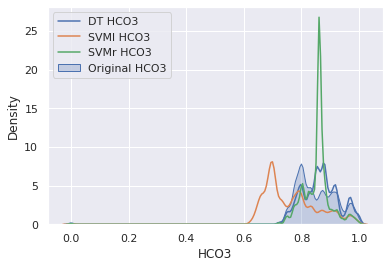

In [9]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

sns.set(color_codes=True)

adt_df = gdf_norm_dt
asvml_df = gdf_norm_svrl
asvmr_df = gdf_norm_svrr

# sns.distplot(gdf_norm.Li);
# sns.distplot(imp.data.Li);

sns.kdeplot(adt_df.HCO3, bw=0.1, label="DT HCO3")
sns.kdeplot(asvml_df.HCO3, bw=0.1, label="SVMl HCO3")
sns.kdeplot(asvmr_df.HCO3, bw=0.1, label="SVMr HCO3")
sns.kdeplot(gdf_norm.HCO3, bw = 0.1, label="Original HCO3", shade=True)
plt.legend()